# Issues in practice: SOLUTIONS

<br><br><br><br><br>

## Which library to use?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import sklearn.linear_model
import torch
from torch import nn, optim

In [2]:
penguins_df = pd.read_csv("../data/penguins.csv")

In [3]:
boston_prices_df = pd.read_csv(
    "../data/boston-house-prices.csv", sep="\s+", header=None,
    names=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"],
)
boston_prices_df = (boston_prices_df - boston_prices_df.mean()) / boston_prices_df.std()

In [4]:
stockmarket_data = [float(x) for x in open("../data/nasdaq-NXPI-20160726-to-20170428.csv")]

<br><br><br><br><br>

## Regression versus classification, loss functions

...

### Categorical → numerical and numerical → categorical

...

### Classification in PyTorch

In [5]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"][["bill_length_mm", "bill_depth_mm"]].dropna()

In [6]:
species = np.concatenate([np.zeros(len(adelie_df)), np.ones(len(gentoo_df))])
bill_depth = np.concatenate([adelie_df["bill_depth_mm"].values, gentoo_df["bill_depth_mm"].values])

In [7]:
# this user-defined model step centers and scales the input
# without this, the optimizer would require many more steps to find the minimum
class NormalizeInput(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(bill_depth.mean(), bill_depth.std())

model = nn.Sequential(      # define a 3-step model
    normalize_input,        # step 1: center/scale the input
    nn.Linear(1, 1),        # step 2: linear transformation (1D → 1D)
    nn.Sigmoid(),           # step 3: pass output through a sigmoid
)

# convert the data into PyTorch Tensors, which are differentiable and can live on a GPU
features = torch.tensor(bill_depth[:, np.newaxis], dtype=torch.float32)
targets = torch.tensor(species[:, np.newaxis], dtype=torch.float32)

# use Binary Cross Entropy as a loss function
loss_function = nn.BCELoss()

# use Adam as an optimizer with a (high) learning rate of 0.03
optimizer = optim.Adam(model.parameters(), lr=0.03)

# iterate over the same data 1000 times (epochs)
for epoch in range(1000):
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # give the model the input features and ask it to compute its predictions
    predictions = model(features)

    # compute the loss between these predictions and the intended targets
    loss = loss_function(predictions, targets)

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

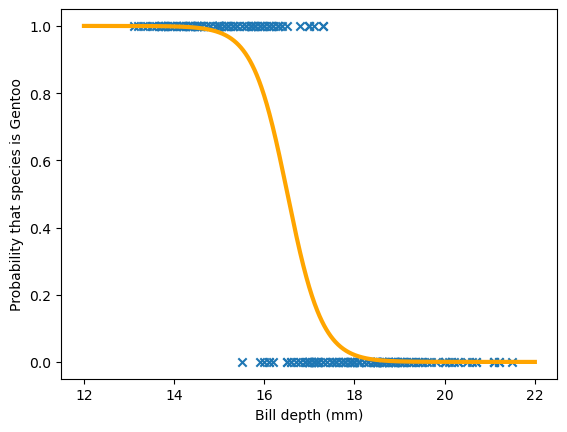

In [8]:
model_x = np.linspace(12, 22, 1000)
model_y = model(torch.tensor(model_x[:, np.newaxis], dtype=torch.float32)).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

### More than two classes

In [9]:
adelie_df["is_adelie"] = 1
gentoo_df["is_gentoo"] = 1
chinstrap_df["is_chinstrap"] = 1

onehot_df = pd.concat([adelie_df, gentoo_df, chinstrap_df]).fillna(0)

In [10]:
features_np = onehot_df[["bill_length_mm", "bill_depth_mm"]].values
targets_np = onehot_df[["is_adelie", "is_gentoo", "is_chinstrap"]].values

<br><br><br><br><br>

### 5-minute exercise: do a logistic regression of 2 features to 3 categories in PyTorch

Uncomment and run the debugging code if it's helpful to do so.

Remember: examine all your variables and look at each step! That's why we're using Python (and Jupyter) in the first place!

In [11]:
features = torch.tensor(features_np, dtype=torch.float32)
targets = torch.tensor(targets_np, dtype=torch.float32)

In [12]:
# features

In [13]:
# targets

In [14]:
class NormalizeInput(nn.Module):
    def __init__(self, mean1, std1, mean2, std2):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean1, mean2], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std1, std2], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(
    features_np[:, 0].mean(), features_np[:, 0].std(),
    features_np[:, 1].mean(), features_np[:, 1].std(),
)
# normalize_input.forward(features)

The softmax function is defined as:

$$ \mbox{softmax}_i(x) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$

Consequentially,

$$ \sum_i \mbox{softmax}_i(x) = 1 $$

When we had only 2 categories, we could focus on only one of them and compute its sigmoid.

With 3 categories, we use the softmax to ensure that the model's output probabilities add to 1.

In [15]:
model_without_softmax = nn.Sequential(
    normalize_input,
    nn.Linear(2, 3),
)
# model_without_softmax

In [16]:
# model_without_softmax(features)

In [17]:
model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)
# model_with_softmax

In [18]:
# model_with_softmax(features)

In the next cell, define a `loss_function`, an `optimizer`, and implement the fit.

Use PyTorch's [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which internally includes the softmax. Don't apply it twice!

In [19]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

for epoch in range(1000):
    optimizer.zero_grad()

    predictions = model_without_softmax(features)

    loss = loss_function(predictions, targets)

    loss.backward()
    optimizer.step()

The next cell plots the fit, just like Scikit-Learn, using the model with the softmax (because we need to plot probabilities).

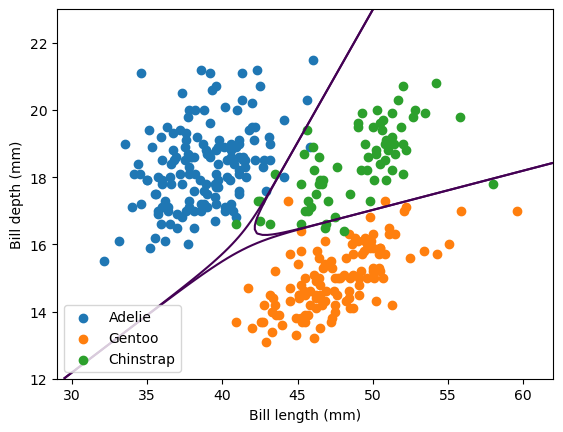

In [20]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model_with_softmax(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

## Optimizers: learning rate, batches, and epochs

...

### 5-minute exercise: optimize a 2D function

In [21]:
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# a PyTorch "model" that just consists of two optimizable parameters
class Position2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.xy = nn.Parameter(torch.tensor([-1, 2], dtype=torch.float32, requires_grad=True))
    def forward(self):
        return self.xy[0], self.xy[1]

Define a optimizer than can find the true minimum of (3, 0.5), replacing the naive one in this cell:

In [22]:
model = Position2D()

optimizer = optim.Adam(model.parameters(), lr=0.3, betas=(0.99, 0.999))

In [23]:
path_start = list(model.parameters())[0].detach().numpy().tolist()

path = [path_start]
for epoch in range(1000):

    # start an optimization step in the usual way
    optimizer.zero_grad()

    # this model has no arguments, and its loss function is beale (unusual!)
    loss = beale(*model())

    # finish an optimization step in the usual way
    loss.backward()
    optimizer.step()

    # keep track of the path, to plot it
    path.append(list(model.parameters())[0].detach().numpy().tolist())

path_np = np.array(path)

print("Final position, should be (3, 0.5):")
print(list(model.parameters())[0])
print()
print("Final loss, should be 0:")
print(loss)

Final position, should be (3, 0.5):
Parameter containing:
tensor([3.0190, 0.5036], requires_grad=True)

Final loss, should be 0:
tensor(5.6613e-05, grad_fn=<AddBackward0>)


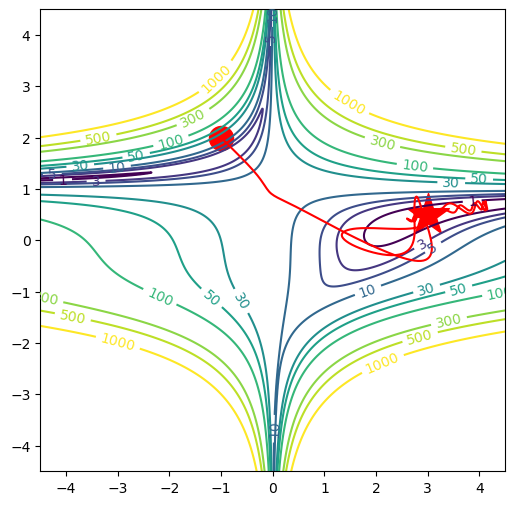

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

background_x, background_y = np.meshgrid(np.linspace(-4.5, 4.5, 1000), np.linspace(-4.5, 4.5, 1000))
contours = ax.contour(background_x, background_y, beale(background_x, background_y), [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000], norm="log")
ax.clabel(contours, contours.levels)
ax.axis([-4.5, 4.5, -4.5, 4.5])

ax.scatter([3], [0.5], marker="*", s=1000, c="red")
ax.scatter([path_start[0]], [path_start[1]], marker="o", s=300, c="red")
ax.plot(path_np[:, 0], path_np[:, 1], c="red")

None

### Batches and epochs

...

<br><br><br><br><br>

## Feature selection and the "kernel trick"

...

<br><br><br><br><br>

## Under & overfitting

<br><br><br><br><br>

## Parameters versus hyperparameters

<br><br><br><br><br>

## Partitioning data into train-test-validate

<br><br><br><br><br>

## Goodness of fit metrics

<br><br><br><br><br>

## Regularization: L1, L2, dropout